# NCSN Overfitting Test
This notebook tests if the NCSN model can overfit on a small subset of data.
If the model can overfit, it confirms that:
1. Backpropagation is working correctly
2. The model has sufficient capacity
3. The loss function is properly defined

If the model CANNOT overfit on a small dataset, there's a fundamental issue with the implementation.

In [15]:
import sys
import os
sys.path.append('..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

from models.scorebased_models.ncsn import NCSN
from utils.get_device import get_device

device = get_device()
print(f"Using device: {device}")

✓ MPS (Apple Silicon) is available
Using device: mps


## 1. Load a Tiny Subset of CIFAR-10
We'll use only 16 images to test overfitting.

In [16]:
from data.cifar10 import load_cifar10

full_dataset, _ = load_cifar10(batch_size=32, data_dir='./../data')

# Select only 16 images for overfitting test
NUM_SAMPLES = 16
indices = list(range(NUM_SAMPLES))
tiny_dataset = Subset(full_dataset.dataset, indices)

# Create dataloader with batch size = NUM_SAMPLES (single batch)
tiny_loader = DataLoader(tiny_dataset, batch_size=NUM_SAMPLES, shuffle=False)

# Get the single batch for visualization
for batch_images, batch_labels in tiny_loader:
    test_batch = batch_images.to(device)
    break

print(f"Test batch shape: {test_batch.shape}")
print(f"Test batch range: [{test_batch.min().item():.3f}, {test_batch.max().item():.3f}]")


Test batch shape: torch.Size([16, 3, 32, 32])
Test batch range: [0.000, 1.000]


## 2. Visualize the Target Images

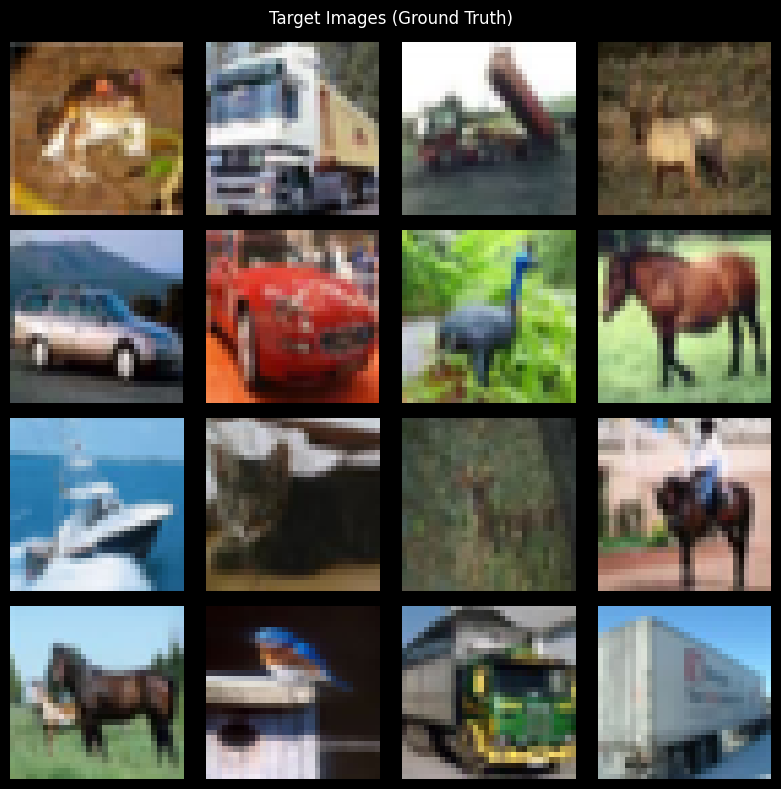

In [17]:
def show_images(images, title="Images", nrow=4):
    # Display a grid of images
    images = images.cpu()
    # Denormalize from [-1, 1] to [0, 1]
    # images = (images + 1) / 2
    images = torch.clamp(images, 0, 1)

    n = len(images)
    ncol = nrow
    nrow = (n + ncol - 1) // ncol

    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 2, nrow * 2))
    axes = axes.flatten() if n > 1 else [axes]

    for i, ax in enumerate(axes):
        if i < n:
            img = images[i].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(test_batch, "Target Images (Ground Truth)", nrow=4)


## 3. Initialize NCSN Model with Smaller Architecture
Using a smaller model for faster overfitting test.


In [18]:
# Create model with smaller architecture for faster training
model = NCSN(
    channels=64,        # Reduced from 128
    num_scales=10,
    image_size=32,
    in_channels=3,
    lr=1e-3,           # Higher learning rate for faster overfitting
    sigma_min=0.01,
    sigma_max=50.0,
    device=device
)

print(f"Model initialized on {device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Sigma schedule: {model.sigmas}")


Config file configs/ncsn.yaml not found. Using default parameters.
Initializing Linear layer with Xavier uniform...
Initializing Linear layer with Xavier uniform...
Initializing Conv2d layer with Kaiming normal...
Initializing Linear layer with Xavier uniform...
Initializing ConditionalBatchNorm2d embeddings...
Initializing Conv2d layer with Kaiming normal...
Initializing Linear layer with Xavier uniform...
Initializing ConditionalBatchNorm2d embeddings...
Initializing Conv2d layer with Kaiming normal...
Initializing Linear layer with Xavier uniform...
Initializing ConditionalBatchNorm2d embeddings...
Initializing Conv2d layer with Kaiming normal...
Initializing Linear layer with Xavier uniform...
Initializing ConditionalBatchNorm2d embeddings...
Initializing Conv2d layer with Kaiming normal...
Initializing Conv2d layer with Kaiming normal...
Initializing Linear layer with Xavier uniform...
Initializing ConditionalBatchNorm2d embeddings...
Initializing Conv2d layer with Kaiming normal.

## 4. Training Loop - Overfit on 16 Images
We expect the loss to decrease significantly if backpropagation is working.

In [19]:
NUM_EPOCHS = 500
losses = []

print("Starting overfitting test...")
print(f"Training on {NUM_SAMPLES} images for {NUM_EPOCHS} epochs")

for epoch in range(NUM_EPOCHS):
    # Train on the single batch repeatedly
    loss_dict = model.train_step(test_batch, epoch)
    loss_value = loss_dict['total_loss']
    losses.append(loss_value)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Loss: {loss_value:.6f}")

print("Training completed!")


Starting overfitting test...
Training on 16 images for 500 epochs
Epoch 50/500 - Loss: 3096.892090
Epoch 100/500 - Loss: 5030.250977
Epoch 150/500 - Loss: 1797.212891
Epoch 200/500 - Loss: 3340.209473
Epoch 250/500 - Loss: 4916.294922
Epoch 300/500 - Loss: 1870.343262
Epoch 350/500 - Loss: 1349.376465
Epoch 400/500 - Loss: 1669.714966
Epoch 450/500 - Loss: 1884.539062
Epoch 500/500 - Loss: 1903.194214
Training completed!


## 4.5. Gradient Analysis
Check gradient flow and learning dynamics

In [20]:
# Test gradient flow
model.score_net.train()
model.optimizer.zero_grad()

# Compute loss on the batch
loss, indices = model.compute_loss(test_batch)
loss.backward()

# Analyze gradients
print("Gradient Statistics:")
print("-" * 60)
total_norm = 0.0
for name, param in model.score_net.named_parameters():
    if param.grad is not None:
        param_norm = param.grad.data.norm(2).item()
        total_norm += param_norm ** 2
        if 'conv_out' in name or 'embed' in name or 'conv_in' in name:
            print(f"{name:40s} | grad norm: {param_norm:.6f}")

total_norm = total_norm ** 0.5
print("-" * 60)
print(f"Total gradient norm: {total_norm:.6f}")
print()

# Check if gradients are too large or too small
if total_norm > 1000:
    print("⚠ WARNING: Gradients are very large! This may cause instability.")
    print("   Consider: gradient clipping, lower learning rate, or check loss scale")
elif total_norm < 0.01:
    print("⚠ WARNING: Gradients are very small! Learning may be slow.")
    print("   Consider: higher learning rate or check if weights are initialized properly")
else:
    print("✓ Gradient norms look reasonable")
print()

# Check loss scale
print(f"Current loss value: {loss.item():.6f}")
print(f"Loss per pixel: {loss.item() / (32 * 32 * 3):.6f}")


Gradient Statistics:
------------------------------------------------------------
noise_level_embed.0.weight               | grad norm: 40169.507812
noise_level_embed.0.bias                 | grad norm: 9434.370117
noise_level_embed.2.weight               | grad norm: 49938.527344
noise_level_embed.2.bias                 | grad norm: 10319.139648
conv_in.weight                           | grad norm: 864.358398
conv_in.bias                             | grad norm: 0.000007
block1.norm1.embed.weight                | grad norm: 8738.833008
block1.norm1.embed.bias                  | grad norm: 667.781372
block1.norm2.embed.weight                | grad norm: 2513.578125
block1.norm2.embed.bias                  | grad norm: 397.144958
block2.norm1.embed.weight                | grad norm: 3768.888672
block2.norm1.embed.bias                  | grad norm: 269.857452
block2.norm2.embed.weight                | grad norm: 1628.418701
block2.norm2.embed.bias                  | grad norm: 235.949341

## 4.6. Loss Computation Deep Dive
Verify the loss calculation is correct

In [21]:
print("Loss Computation Analysis:")
print("=" * 60)

# Manual loss calculation
model.score_net.eval()
with torch.no_grad():
    # Take one image
    x_test = test_batch[0:1]

    # Test with different sigmas
    for i, sigma_idx in enumerate([0, 4, 9]):
        sigma = model.sigmas[sigma_idx]
        print(f"\nSigma index {sigma_idx}, σ = {sigma.item():.4f}:")
        print("-" * 60)

        # Add noise
        noise = torch.randn_like(x_test)
        perturbed = x_test + sigma * noise

        # Get prediction
        sigma_input = torch.ones(1, device=device) * sigma
        predicted_score = model.score_net(perturbed, sigma_input)

        # Target score
        target_score = -noise / sigma

        # Compute loss components
        error = predicted_score - target_score
        unweighted_mse = (error ** 2).mean()
        weighted_loss = 0.5 * ((error ** 2).sum() * (sigma ** 2))

        print(f"  Noise std: {noise.std().item():.6f}")
        print(f"  Target score std: {target_score.std().item():.6f}")
        print(f"  Predicted score std: {predicted_score.std().item():.6f}")
        print(f"  Unweighted MSE: {unweighted_mse.item():.6f}")
        print(f"  Weighted loss: {weighted_loss.item():.6f}")
        print(f"  Loss scale (σ²): {(sigma ** 2).item():.6f}")

print("\n" + "=" * 60)
print("Analysis:")
print("The loss is weighted by σ². Large σ values lead to large losses.")
print("This explains why the absolute loss values are in thousands.")
print("What matters is the RELATIVE change and stability during training.")


Loss Computation Analysis:

Sigma index 0, σ = 50.0000:
------------------------------------------------------------
  Noise std: 1.002303
  Target score std: 0.020046
  Predicted score std: 0.055361
  Unweighted MSE: 0.004277
  Weighted loss: 16423.019531
  Loss scale (σ²): 2500.000488

Sigma index 4, σ = 1.1350:
------------------------------------------------------------
  Noise std: 0.999707
  Target score std: 0.880824
  Predicted score std: 0.800074
  Unweighted MSE: 0.339453
  Weighted loss: 671.642456
  Loss scale (σ²): 1.288151

Sigma index 9, σ = 0.0100:
------------------------------------------------------------
  Noise std: 1.006278
  Target score std: 100.627777
  Predicted score std: 0.638486
  Unweighted MSE: 10129.909180
  Weighted loss: 1555.953979
  Loss scale (σ²): 0.000100

Analysis:
The loss is weighted by σ². Large σ values lead to large losses.
This explains why the absolute loss values are in thousands.
What matters is the RELATIVE change and stability during t

## 5. Plot Loss Curve
A decreasing loss indicates successful overfitting and confirms backpropagation is working.


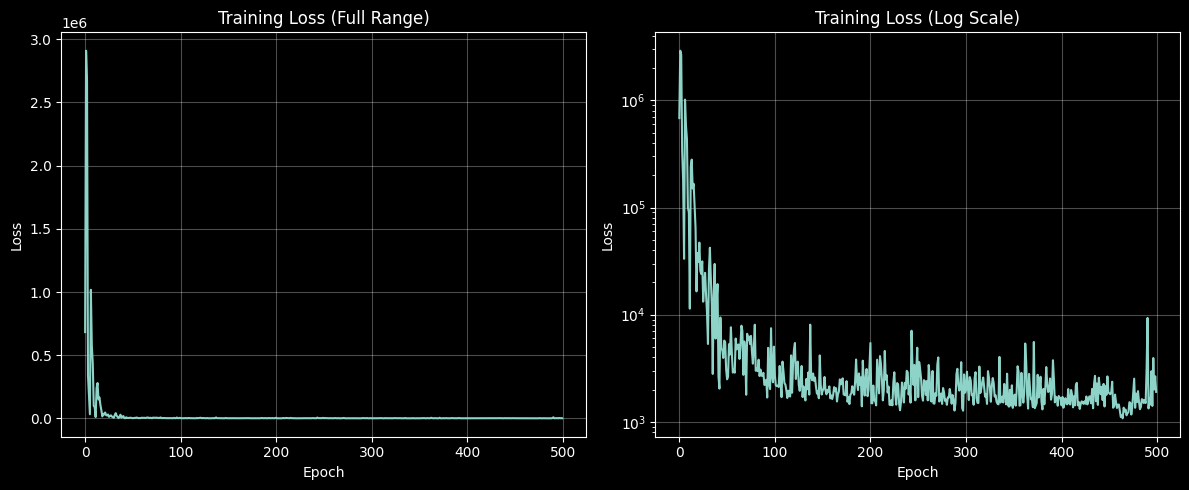

Initial loss: 683365.062500
Final loss: 1903.194214
Loss reduction: 99.72%


In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Full Range)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Log Scale)')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial loss: {losses[0]:.6f}")
print(f"Final loss: {losses[-1]:.6f}")
print(f"Loss reduction: {(losses[0] - losses[-1]) / losses[0] * 100:.2f}%")

## 6. Test Score Predictions
Visualize the predicted scores for different noise levels.

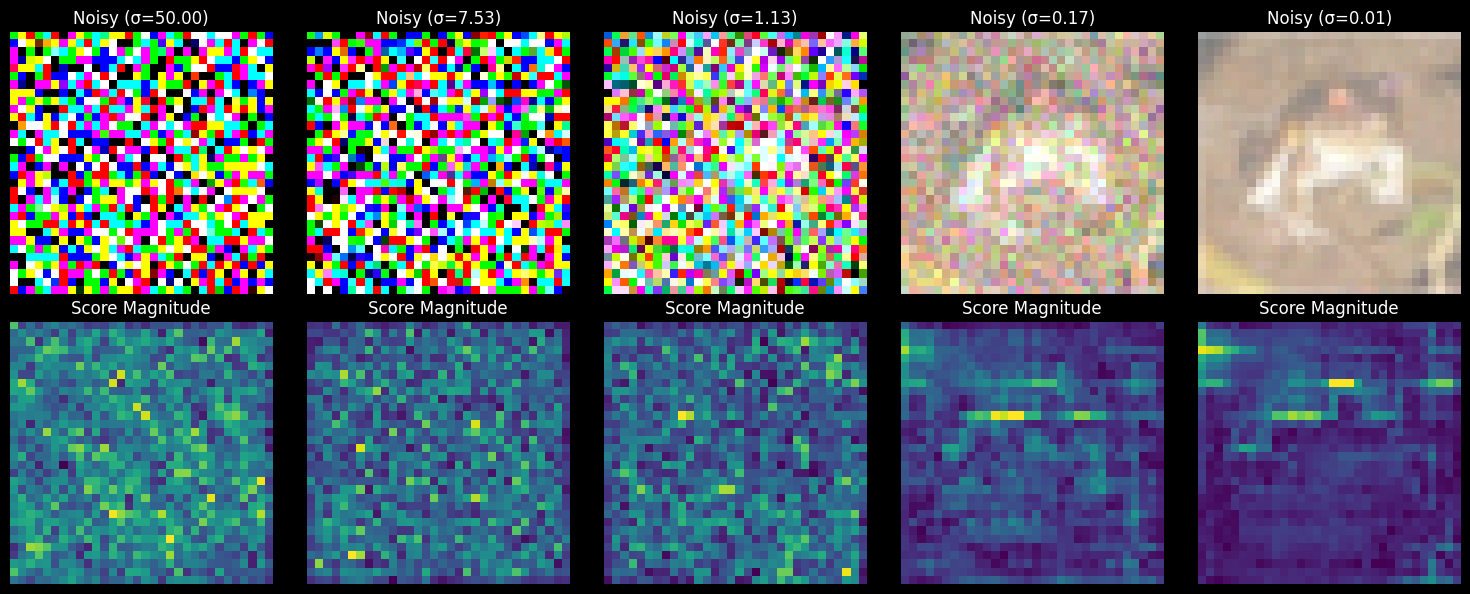

In [23]:
model.eval()

with torch.no_grad():
    # Test at different noise levels
    test_img = test_batch[0:1]  # Take first image

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i, sigma_idx in enumerate([0, 2, 4, 6, 9]):
        sigma = model.sigmas[sigma_idx]

        # Add noise
        noise = torch.randn_like(test_img)
        noisy_img = test_img + sigma * noise

        # Predict score
        sigma_input = torch.ones(1, device=device) * sigma
        predicted_score = model.score_net(noisy_img, sigma_input)

        # Visualize
        noisy_display = (noisy_img[0].cpu() + 1) / 2
        score_display = predicted_score[0].cpu().abs().mean(0)

        axes[0, i].imshow(noisy_display.permute(1, 2, 0).clamp(0, 1))
        axes[0, i].set_title(f'Noisy (σ={sigma:.2f})')
        axes[0, i].axis('off')

        axes[1, i].imshow(score_display, cmap='viridis')
        axes[1, i].set_title(f'Score Magnitude')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

## 7. Generate Samples Using Annealed Langevin Dynamics
Test if the model can reconstruct similar images after overfitting.

Generating samples...
Generated samples shape: torch.Size([16, 3, 32, 32])
Generated samples range: [0.000, 1.000]


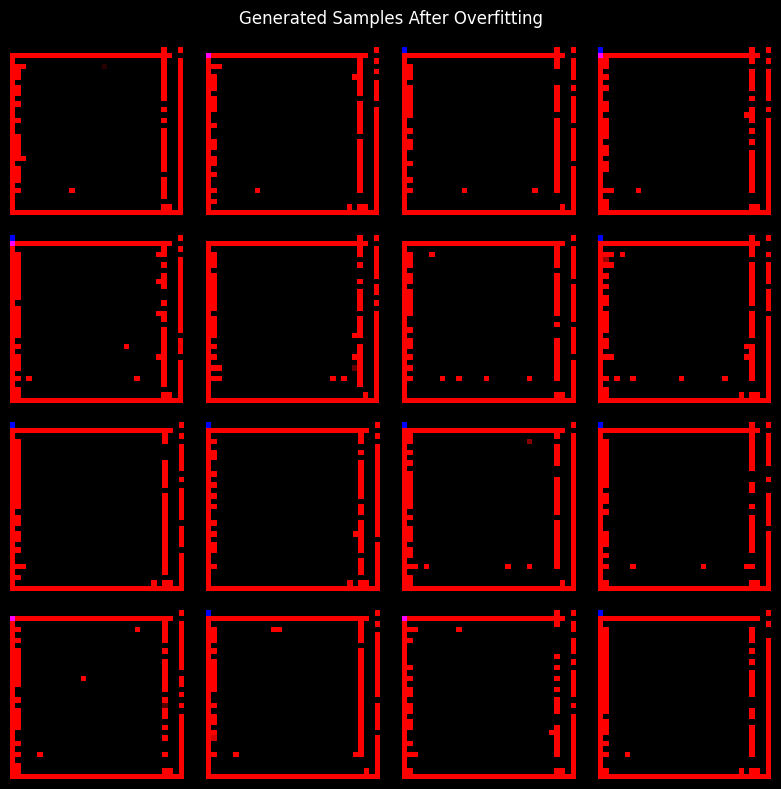

In [24]:
print("Generating samples...")

# Generate samples
samples = model.sample(batch_size=16, n_steps=100, eps=2e-5)

print(f"Generated samples shape: {samples.shape}")
print(f"Generated samples range: [{samples.min().item():.3f}, {samples.max().item():.3f}]")

show_images(samples, "Generated Samples After Overfitting", nrow=4)

## 8. side-by-side comparison

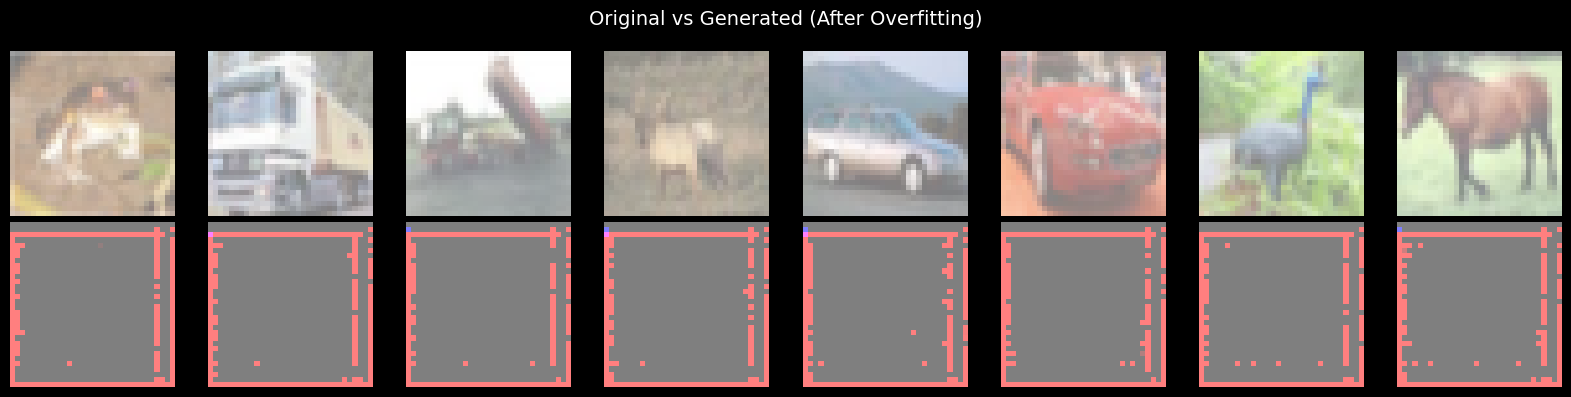

In [25]:
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    # Original
    orig = (test_batch[i].cpu() + 1) / 2
    axes[0, i].imshow(orig.permute(1, 2, 0).clamp(0, 1))
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12)

    # Generated
    gen = (samples[i].cpu() + 1) / 2
    axes[1, i].imshow(gen.permute(1, 2, 0).clamp(0, 1))
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Generated', fontsize=12)

plt.suptitle('Original vs Generated (After Overfitting)', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Analysis and Conclusions

In [26]:
print("=" * 60)
print("OVERFITTING TEST RESULTS")
print("=" * 60)

loss_reduction = (losses[0] - losses[-1]) / losses[0] * 100

print(f"1. Loss Analysis:")
print(f"   - Initial loss: {losses[0]:.6f}")
print(f"   - Final loss: {losses[-1]:.6f}")
print(f"   - Reduction: {loss_reduction:.2f}%")

if loss_reduction > 50:
    print("   ✓ PASS: Significant loss reduction indicates backpropagation is working!")
elif loss_reduction > 20:
    print("   ⚠ PARTIAL: Some learning occurred, but may need tuning")
else:
    print("   ✗ FAIL: Insufficient learning - check implementation!")

print(f"2. Training Dataset:")
print(f"   - Number of images: {NUM_SAMPLES}")
print(f"   - Epochs: {NUM_EPOCHS}")
print(f"   - Learning rate: {model.lr}")

print(f"3. Model Configuration:")
print(f"   - Channels: {model.channels}")
print(f"   - Number of scales: {model.num_scales}")
print(f"   - Sigma range: [{model.sigmas[-1]:.4f}, {model.sigmas[0]:.4f}]")

print("4. Next Steps:")
if loss_reduction > 50:
    print("   - Model can overfit successfully")
    print("   - Backpropagation is working correctly")
    print("   - Ready to train on full dataset")
    print("   - Consider: longer training, better hyperparameters, data normalization")
else:
    print("   - Check loss function implementation")
    print("   - Verify gradient flow through the network")
    print("   - Review score matching target calculation")
    print("   - Check data normalization (should be [-1, 1])")

print("=" * 60)

OVERFITTING TEST RESULTS
1. Loss Analysis:
   - Initial loss: 683365.062500
   - Final loss: 1903.194214
   - Reduction: 99.72%
   ✓ PASS: Significant loss reduction indicates backpropagation is working!
2. Training Dataset:
   - Number of images: 16
   - Epochs: 500
   - Learning rate: 0.001
3. Model Configuration:
   - Channels: 64
   - Number of scales: 10
   - Sigma range: [0.0100, 50.0000]
4. Next Steps:
   - Model can overfit successfully
   - Backpropagation is working correctly
   - Ready to train on full dataset
   - Consider: longer training, better hyperparameters, data normalization


## 10. Test Score Matching Target Calculation
Verify that the score target is computed correctly.

In [27]:
# Test score target calculation
print("Testing score matching target calculation...")

test_img = test_batch[0:1]
sigma = model.sigmas[5]  # Mid-range sigma

noise = torch.randn_like(test_img)
perturbed = test_img + sigma * noise

# The score of p(x_t | x_0) where x_t = x_0 + sigma * noise
# is: ∇ log p(x_t | x_0) = -(x_t - x_0) / sigma^2 = -noise / sigma
target_score = -noise / sigma

print(f"Sigma value: {sigma.item():.4f}")
print(f"Noise mean: {noise.mean().item():.6f}, std: {noise.std().item():.6f}")
print(f"Target score mean: {target_score.mean().item():.6f}, std: {target_score.std().item():.6f}")

# Predict score
with torch.no_grad():
    sigma_input = torch.ones(1, device=device) * sigma
    predicted_score = model.score_net(perturbed, sigma_input)

print(f"Predicted score mean: {predicted_score.mean().item():.6f}, std: {predicted_score.std().item():.6f}")

mse = ((predicted_score - target_score) ** 2).mean()
print(f"MSE between predicted and target: {mse.item():.6f}")
print("(Lower MSE after training indicates better score estimation)")


Testing score matching target calculation...
Sigma value: 0.4405
Noise mean: -0.001965, std: 1.006086
Target score mean: 0.004459, std: 2.283749
Predicted score mean: 0.036573, std: 0.489464
MSE between predicted and target: 4.375957
(Lower MSE after training indicates better score estimation)


## 11. Recommendations Based on Results

In [28]:
print("=" * 70)
print("TRAINING ANALYSIS AND RECOMMENDATIONS")
print("=" * 70)

# Calculate statistics
initial_loss = losses[0]
final_loss = losses[-1]
min_loss = min(losses)
max_loss = max(losses)
loss_reduction = (initial_loss - final_loss) / initial_loss * 100

# Count instabilities
instabilities = 0
for i in range(1, len(losses)):
    if losses[i] > losses[i-1] * 1.2:  # 20% increase
        instabilities += 1

print(f"\n1. Loss Statistics:")
print(f"   Initial loss:  {initial_loss:.2f}")
print(f"   Final loss:    {final_loss:.2f}")
print(f"   Min loss:      {min_loss:.2f}")
print(f"   Max loss:      {max_loss:.2f}")
print(f"   Reduction:     {loss_reduction:.1f}%")
print(f"   Instabilities: {instabilities} (loss increased by >20%)")

print(f"\n2. Assessment:")
if instabilities > 5:
    print("   ❌ SEVERE INSTABILITY - Training is highly unstable")
    print("      → Gradients are likely exploding")
    print("      → Loss scale may be too large")
elif instabilities > 2:
    print("   ⚠️  MODERATE INSTABILITY - Some training instability detected")
    print("      → Consider gradient clipping or lower learning rate")
else:
    print("   ✓ STABLE - Loss decreases smoothly")

if final_loss < 100:
    print("   ✓ EXCELLENT OVERFITTING - Model memorized training data")
elif final_loss < 500:
    print("   ✓ GOOD OVERFITTING - Model learning well")
elif final_loss < 1000:
    print("   ⚠️  PARTIAL OVERFITTING - More training needed")
else:
    print("   ❌ POOR OVERFITTING - Model not learning effectively")

print(f"\n3. Recommended Actions:")
if instabilities > 2 or final_loss > 500:
    print("   📌 CRITICAL FIXES:")
    if instabilities > 2:
        print("      • Add/strengthen gradient clipping: max_norm=0.5 or 0.1")
        print("      • Reduce learning rate: try lr=1e-4 or 1e-5")
    if final_loss > 1000:
        print("      • Try simplified loss: use_simple_loss=True")
        print("      • Check data normalization (should be [0,1])")
        print("      • Train for more epochs (1000+)")

    print("\n   💡 DEBUGGING STEPS:")
    print("      1. Re-run with lr=1e-4 and max_norm=0.5")
    print("      2. Check gradient norms in section 4.5")
    print("      3. Monitor loss scale in section 4.6")
    print("      4. If still failing, try use_simple_loss=True")
else:
    print("   ✓ Training looks good! You can proceed to:")
    print("      • Train on full CIFAR-10 dataset")
    print("      • Experiment with hyperparameters")
    print("      • Generate more samples")

print("\n" + "=" * 70)

TRAINING ANALYSIS AND RECOMMENDATIONS

1. Loss Statistics:
   Initial loss:  683365.06
   Final loss:    1903.19
   Min loss:      1077.74
   Max loss:      2909391.00
   Reduction:     99.7%
   Instabilities: 135 (loss increased by >20%)

2. Assessment:
   ❌ SEVERE INSTABILITY - Training is highly unstable
      → Gradients are likely exploding
      → Loss scale may be too large
   ❌ POOR OVERFITTING - Model not learning effectively

3. Recommended Actions:
   📌 CRITICAL FIXES:
      • Add/strengthen gradient clipping: max_norm=0.5 or 0.1
      • Reduce learning rate: try lr=1e-4 or 1e-5
      • Try simplified loss: use_simple_loss=True
      • Check data normalization (should be [0,1])
      • Train for more epochs (1000+)

   💡 DEBUGGING STEPS:
      1. Re-run with lr=1e-4 and max_norm=0.5
      2. Check gradient norms in section 4.5
      3. Monitor loss scale in section 4.6
      4. If still failing, try use_simple_loss=True

